# Comparison of radial convergence profiles

This notebook aims at generating the plot of Millon et al. (in prep.). The plot shows a comparison of _azimuthally averaged_ convergence profiles for different model families, that were fitted on a set of mock strong lenses.

Model families used to __simulate__ the data :
- SPEMD (seeds 211, 212, 219)
- core-SPEMD (seeds 213, 214, 220)
- composite = elliptical Hernquist + NFW (seeds 215, 216, 217, 218, 221)

And same model families used to __fit__ the data.

For composite data and models, the Hernquist profile is linked to the light distribution through a constant mass-to-light ratio.

This script was tested using the version 1.1.0 of lenstronomy

In [1]:
# some module imports
import IPython

import os
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from TDLMCpipeline.SimuModelFlexibility.structure import MockStructure
from TDLMCpipeline.Modelling.model_extensions import ModelExtensions
from TDLMCpipeline.Pipeline.io_manager import IOManager
from TDLMCpipeline.Util import util
from TDLMCpipeline.Util import cosmo

%matplotlib inline

## Setup truth and models

In [2]:
delta_pix = 0.08  # size of pixel in arcsec
r_aperture = 0.5  # radius of the spectroscopic arcsec (for kinematics)
num_pix = 99

base_dir = 'data'

seed_list = range(211, 217)

truth_data = {
    'model_dir': {
        211: 'spemd_true_truetd_recompute_noise_map_191118-165458',
        212: 'spemd_true_truetd_191115-120433',
        213: 'spemd_true_truetd_191115-120519',
        214: 'spemd_true_truetd_191115-134542',
        215: 'truth_mask3pix_gauss-kernel_191125-135102',
        216: 'truth_mask3pix_gauss-kernel_191125-133413',
        217: 'truth_mask3pix_gauss-kernel_191126-142253',
        218: 'truth_mask3pix_gauss-kernel_191126-145359',
    },
    'title': {
        211: "power law #1",
        212: "power law #2",
        213: "cored power law #3",
        214: "cored power law #4",
        215: "composite #5",
        216: "composite #6",
        #217: "composite #7",
        #218: "composite #8",
    },
    'label': "truth",
    'plot_kwargs': {'color': 'black', 'linewidth': 3, 'linestyle': ':', 'zorder': 6},
}

model_data = {
    'model_dir_list': {
        211: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-021719',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022359',
            None, #'composite_std-start_no-astrometry_mask3pix_repro-kinem_191128-131653',
        ],
        212: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-021929',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022428',
            None, #'composite_std-start_no-astrometry_mask3pix_repro-kinem_191128-131653',
        ],
        213: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022029',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022631',
            None, #'composite_std-start_no-astrometry_mask3pix_repro-kinem_191128-131653',
        ],
        214: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022059',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022631',
            None, #'composite_std-start_no-astrometry_mask3pix_repro-kinem_191128-131653',
        ],
        215: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022158',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022659 2',
            'composite_std-start_no-astrometry_mask3pix_repro-kinem_191203-222846',
        ],
        216: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191128-022259',
            'corespemd_true_delay_err1_nonooffset_recompute_noise_mask3_rerun_191204-121318',
            'composite_std-start_no-astrometry_mask3pix_repro-kinem_191203-223109',
        ],
        217: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_191126-181654',
            None,
            'composite_std-start_no-astrometry_mask3pix_repro-kinem_191204-011525',
        ],
        218: [
            'spemd_true_delay_err1_nonooffset_recompute_noise_mask3_191126-181654',
            None,
            'composite_std-start_no-astrometry_mask3pix_repro-kinem_191204-013655',
        ],
    },
    'label_list': ["power law", "cored power law", "composite"],
    'color_list': ['#379CD0', '#25AB1F', '#E04F4A', '#888888'],
    'linestyle_list': ['-', '--', '-.', ':'],
    'plot_kwargs': {'linewidth': 2, 'zorder': 4}
}

misc_data = {
    'einstein_radius': {
        'label': "Einstein radius",
        'line_kwargs': {'color': '#888888', 'linewidth': 2, 'linestyle': '--', 'zorder': 3},
    },
    'images_range': {
        'label': "Images range",
        'line_kwargs': {'color': '#AAAAAA', 'linewidth': 2, 'linestyle': '--', 'zorder': 2},
        'span_kwargs': {'color': 'black', 'alpha': 0.1, 'zorder': 1},
    },
    'spectro_aperture': {
        'label': "Spectro. aperture",
        'line_kwargs': {'color': '#888888', 'linewidth': 2, 'linestyle': ':', 'zorder': 1},
    },
    'zero_error': {
        'line_kwargs': {'color': 'black', 'alpha': 0.2, 'linewidth': 1, 'linestyle': '-', 'zorder': 0},
    }
}

axis_limits = {
    'radius': [
        # format : [axis limits, tick locations, labels location]
        (0.09, 3.2),  # arcsec
        [0.1, 0.3, 0.5, 1, 3],  # arcsec
        ["0.1", "0.3", "0.5", "1", "3"],  # arcsec
    ],
    'kappa': {
        211: [(2e-1, 6e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],  # format : [axis limits, tick locations, labels location]
        212: [(2e-1, 6e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],
        213: [(2e-1, 4e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],
        214: [(2e-1, 4e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],
        215: [(2e-1, 4e0), [3e-1, 1e0, 3e0], ["0.3", "1", "3"]],
        216: [(5e-1, 2e0), [6e-1, 1e0, 2e0], ["0.6", "1", "2"]],
    },
    'error': [
        # format : [axis limits, tick locations, labels location]
        #(-20, 20), [-20, -10, 0, 10, 20], [r"$-20\%$", "", r"$0$", "", r"$+20\%$"]
        (-10, 10), [-10, -5, 0, 5, 10], [r"$-10\%$", "", r"$0$", "", r"$+10\%$"]
    ],
    #'error': {
    #    211: [(-10, 10), [-10, -5, 0, 5, 10], [r"$-10\%$", "", r"$0$", "", r"$+10\%$"]],  # format : [axis limits, tick locations, labels location]
    #    212: [(-10, 10), [-10, -5, 0, 5, 10], [r"$-10\%$", "", r"$0$", "", r"$+10\%$"]],
    #    213: [(-10, 10), [-10, -5, 0, 5, 10], [r"$-10\%$", "", r"$0$", "", r"$+10\%$"]],
    #    214: [(-10, 10), [-10, -5, 0, 5, 10], [r"$-10\%$", "", r"$0$", "", r"$+10\%$"]],
    #    215: [(-10, 10), [-10, -5, 0, 5, 10], [r"$-10\%$", "", r"$0$", "", r"$+10\%$"]],
    #    216: [(-10, 10), [-10, -5, 0, 5, 10], [r"$-10\%$", "", r"$0$", "", r"$+10\%$"]],
    #}
}

## Setup the figure layout

In [3]:
fontsize_general = 16
fontsize_ticklabels = 12
fontsize_text_model = 14
fontsize_text_data = 12
plt.rc('font', size=fontsize_general)
plt.rc('xtick', labelsize=fontsize_ticklabels)
plt.rc('ytick', labelsize=fontsize_ticklabels)
#plt.rc('text', usetex=True)

fig = plt.figure(figsize=(14, 20), constrained_layout=False)
gs = fig.add_gridspec(4, 2, wspace=0.15, hspace=0.3, 
                      width_ratios=[1, 1], height_ratios=[0.05, 1, 1, 1])

ax_legend = fig.add_subplot(gs[0, :])
#ax_legend.text(0.5, 0.5, "[legend placeholder]", ha='center', va='center')
ax_legend.axis('off')

axes_data = {}
row_idx = 1
for s, seed in enumerate(seed_list):
    col_idx = s % 2
    
    # panel 1 : kappa radial profiles
    ax_model = fig.add_subplot(gs[row_idx, col_idx])
    if col_idx == 0:
        ax_model.set_ylabel(r"$\langle\kappa(r)\rangle$")
    
    # panel 2 : error wrt to truth
    divider = make_axes_locatable(ax_model)
    ax_error = divider.append_axes('bottom', pad=0.1, size='25%')
    ax_error.set_xlabel(r"$r$ [arcsec]")
    if col_idx == 0:
        ax_error.set_ylabel("error")
    
    axes_data[seed] = (ax_model, ax_error)
    if col_idx == 1:
        row_idx += 1
        
# UNCOMMENT this to show naked layout
plt.close()

print(axes_data.keys())


dict_keys([211, 212, 213, 214, 215, 216])


## Define functions to retrieve data

In [4]:
def get_radial_quantities_from_model(model_dir):
    # extract data
    input_data_path  = os.path.join(model_dir, 'fit_input_sampling.pkl')
    output_data_path = os.path.join(model_dir, 'fit_output_sampling.pkl')
    input_data, output_data = IOManager.load_fit_data(input_data_path, output_data_path, ensure_compatibility=True)
    model_ext = ModelExtensions(input_data, output_data, bestfit_from_mcmc=True)
    print("BIC best fit : {:.1f}".format(model_ext.BIC_bestfit))
    
    # radial convergence
    r, kappa_r_total = model_ext.convergence_radial_profile()
    
    # AGN image radius range
    r_min, r_max = model_ext.radial_image_position_range()
    
    # Einstein radius
    r_einstein = model_ext.effective_einstein_radius()
    
    return r, kappa_r_total, r_min, r_max, r_einstein

def get_inferred_cosmology(seed, model_dir, from_Ddt_Dd_inference=False, last_num_samples=5000):
    if from_Ddt_Dd_inference:
        inference_data_path = os.path.join(model_dir, 'infer_kde_output-Ddt_params.pkl')
        H0_post_list, bool_load = IOManager.load_pickle(inference_data_path, verbose=True)
        if not bool_load:
            print("Warning : could not load inference data")
            return np.nan, np.nan, np.nan
        else:
            H0_posterior = H0_post_list[0]
    else:
        mock_structure = MockStructure(seed)
        #input_data_path  = os.path.join(model_dir, 'fit_input_sampling.pkl')
        #output_data_path = os.path.join(model_dir, 'fit_output_sampling.pkl')
        #_, output_data = IOManager.load_fit_data(input_data_path, output_data_path, ensure_compatibility=True)
        #chain_list = output_data[1]
        #samples, param_names, _ = util.samples_from_chain_list(chain_list, chain_idx=-1)
        #Ddt_posterior = samples[:, param_names.index('D_dt')]
        postpro_path = os.path.join(model_dir, 'postpro_data.pkl')
        postpro_data, bool_load = IOManager.load_pickle(postpro_path, verbose=True)
        Ddt_posterior = postpro_data['param_Ddt']
        if len(Ddt_posterior) > last_num_samples:
            print("Warning : cut Ddt chain to last {} samples".format(last_num_samples))
            Ddt_posterior = Ddt_posterior[-last_num_samples:]
        H0_posterior  = cosmo.Ddt_2_H0(Ddt_posterior, mock_structure.lens.z_lens, mock_structure.lens.z_source, 
                                       mock_structure.cosmo.omega_m, mock_structure.cosmo.omega_l)
    #H0_value, H0_error_neg, H0_error_pos = util.inference_from_distrib(H0_posterior)
    h016, h050, h084 = np.percentile(H0_posterior, [16, 50, 84])
    H0_value, H0_error_neg, H0_error_pos = h050, h050 - h016, h084 - h050
    return H0_value, H0_error_neg, H0_error_pos

def render_H0_text(val, err_minus=None, err_plus=None, unit=False):
    if err_minus is None or err_plus is None:
        if unit:
            return r'$%.1f\, \rm{km\,s^{-1}\,Mpc^{-1}}$' % val
        else:
            return r'$%.1f$' % val
    if unit:
        return r'$%.1f_{-%.1f}^{+%.1f}\, \rm{km\,s^{-1}\,Mpc^{-1}}$' \
            % (val, err_minus, err_plus)
    else:
        return r'$H_0 : %.1f_{-%.1f}^{+%.1f}$' % (val, err_minus, err_plus)

## Loop over lenses to plot profiles, errors, texts, ...

In [5]:
line_list, label_list = [], []
for s, seed in enumerate(seed_list):
    print("{} seed {} {}".format("="*10, seed, "="*10))
    ax_model, ax_error = axes_data[seed]

    # indicate name of the data
    truth_text = "truth: " + truth_data['title'][seed]
    ax_model.text(0.03, 0.05, truth_text, horizontalalignment='left', verticalalignment='bottom',
                  transform=ax_model.transAxes, fontsize=fontsize_text_data, bbox={'facecolor': 'white', 'alpha': 0.7})
    
    # plot aperture location    
    ax_model.axvline(r_aperture, **misc_data['spectro_aperture']['line_kwargs'])
    ax_error.axvline(r_aperture, **misc_data['spectro_aperture']['line_kwargs'])
    
    # get quantities from 'truth' model
    truth_dir = os.path.join(base_dir, 's{}'.format(seed), truth_data['model_dir'][seed])
    r_truth, kappa_r_truth, r_min, r_max, r_einstein = get_radial_quantities_from_model(truth_dir)
    
    # plot the lensed images range
    #ax_model.axvline(r_min, **misc_data['images_range']['line_kwargs'])
    #ax_model.axvline(r_max, **misc_data['images_range']['line_kwargs'])
    ax_model.axvspan(r_min, r_max, **misc_data['images_range']['span_kwargs'])
    ax_error.axvspan(r_min, r_max, **misc_data['images_range']['span_kwargs'])
    
    # plot Einstein ring location
    ax_model.axvline(r_einstein, **misc_data['einstein_radius']['line_kwargs'])
    ax_error.axvline(r_einstein, **misc_data['einstein_radius']['line_kwargs'])
    
    # plot quantities from fitted models
    text_offset = 0
    for m, model_dir_ in enumerate(model_data['model_dir_list'][seed]):
        if model_dir_ is None:
            continue
        print("{} model {} {}".format("-"*5, model_data['label_list'][m], "-"*5))
        
        # get quantities from the fitted model
        model_dir = os.path.join(base_dir, 's{}'.format(seed), model_dir_)
        r_model, kappa_r_model, _, _, _ = get_radial_quantities_from_model(model_dir)
        #print(seed, kappa_r_model.shape, kappa_r_truth.shape)
        
        # because of numerics when compute azimuthally averaged profiles, profiles may not have the same length
        # in those case, only the outer radius is different, so we discard the last values if needed
        min_len = min(len(r_truth), len(r_model))
        if len(r_truth) != min_len:
            r_truth = r_truth[:min_len]
            kappa_r_truth = kappa_r_truth[:min_len]
        elif len(r_model) != min_len:
            r_model = r_model[:min_len]
            kappa_r_model = kappa_r_model[:min_len]
        
        # plot the modelled profile
        line_model, = ax_model.plot(r_model, kappa_r_model, #label=model_data['label_list'][m], 
                                    color=model_data['color_list'][m], linestyle=model_data['linestyle_list'][m],
                                    **model_data['plot_kwargs'])
        
        # indicate H0, BIC, etc...
        H0_value, H0_n, H0_p = get_inferred_cosmology(seed, model_dir, from_Ddt_Dd_inference=False)
        H0_text = render_H0_text(H0_value, H0_n, H0_p, unit=False)
        ax_model.text(0.05, 0.2+text_offset, H0_text, horizontalalignment='left', verticalalignment='bottom',
                      color=model_data['color_list'][m], transform=ax_model.transAxes, fontsize=fontsize_text_model)
        text_offset += 0.15
        
        # compute relative error
        rel_error = (kappa_r_truth-kappa_r_model)/kappa_r_truth
        ax_error.plot(r_model, rel_error * 100., #label=model_data['label_list'][m], 
                      color=model_data['color_list'][m], linestyle=model_data['linestyle_list'][m],
                      **model_data['plot_kwargs'])
        ax_error.axhline(0, **misc_data['zero_error']['line_kwargs'])
        
        # add to legend list
        model_text = "model: " + model_data['label_list'][m]
        if model_text not in label_list:
            label_list.append(model_text)
            line_list.append(line_model)
    
    # plot the true profile
    line_truth, = ax_model.plot(r_truth, kappa_r_truth, #label=truth_data['label'], 
                               **truth_data['plot_kwargs'])
    # add to legend list
    if truth_data['label'] not in label_list:
        label_list.insert(0, truth_data['label'])
        line_list.insert(0, line_truth)
    
    # for some reason, we have to set some limits and ticks/labels *after* the plots
    plot_radius_range, plot_radius_ticks, plot_radius_labels = axis_limits['radius']
    plot_kappa_range, plot_kappa_ticks, plot_kappa_labels = axis_limits['kappa'][seed]
    plot_error_range, plot_error_ticks, plot_error_labels = axis_limits['error']
    
    ax_model.set_xscale('log')
    ax_model.set_xlim(*plot_radius_range)
    ax_model.set_xticks(plot_radius_ticks)
    ax_model.set_xticklabels([""]*len(plot_radius_ticks))
    ax_model.set_yscale('log')
    ax_model.set_ylim(*plot_kappa_range)
    ax_model.set_yticks(plot_kappa_ticks)
    ax_model.set_yticklabels(plot_kappa_labels)
    
    ax_error.set_xscale('log')
    ax_error.set_xlim(*plot_radius_range)
    ax_error.set_xticks(plot_radius_ticks)
    ax_error.set_xticklabels(plot_radius_labels)
    ax_error.set_ylim(*plot_error_range)
    ax_error.set_yticks(plot_error_ticks)
    ax_error.set_yticklabels(plot_error_labels)
    
    ax_model.grid('on', alpha=0.3)
    
# place the legend in the upper pannel
ax_legend, _ = axes_data[seed_list[0]]
ax_legend.legend(handles=line_list, labels=label_list, ncol=4, bbox_to_anchor=(1.07, 1.2), 
                loc='center', frameon=True, borderaxespad=0)

#fig.tight_layout()
#fig.subplots_adjust(left=None, bottom=None, right=None, top=None)

========== seed 211 ==========
BIC best fit : 7507.9
----- model power law -----


/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


BIC best fit : 8921.7
----- model cored power law -----
BIC best fit : 8931.8
========== seed 212 ==========
BIC best fit : 15951.8
----- model power law -----
BIC best fit : 8543.9
----- model cored power law -----
BIC best fit : 8555.0
========== seed 213 ==========
BIC best fit : 15781.9
----- model power law -----
BIC best fit : 12684.5
----- model cored power law -----
BIC best fit : 8536.6
========== seed 214 ==========
BIC best fit : 16623.8
----- model power law -----
BIC best fit : 16198.3
----- model cored power law -----
BIC best fit : 8529.7
========== seed 215 ==========
BIC best fit : 8298.4
----- model power law -----
BIC best fit : 8774.6
----- model cored power law -----
BIC best fit : 8477.9
----- model composite -----
BIC best fit : 8393.8
========== seed 216 ==========
BIC best fit : 8385.4
----- model power law -----
BIC best fit : 12438.0
----- model cored power law -----
BIC best fit : 9446.5
----- model composite -----
BIC best fit : 8487.0


## Display & save figure

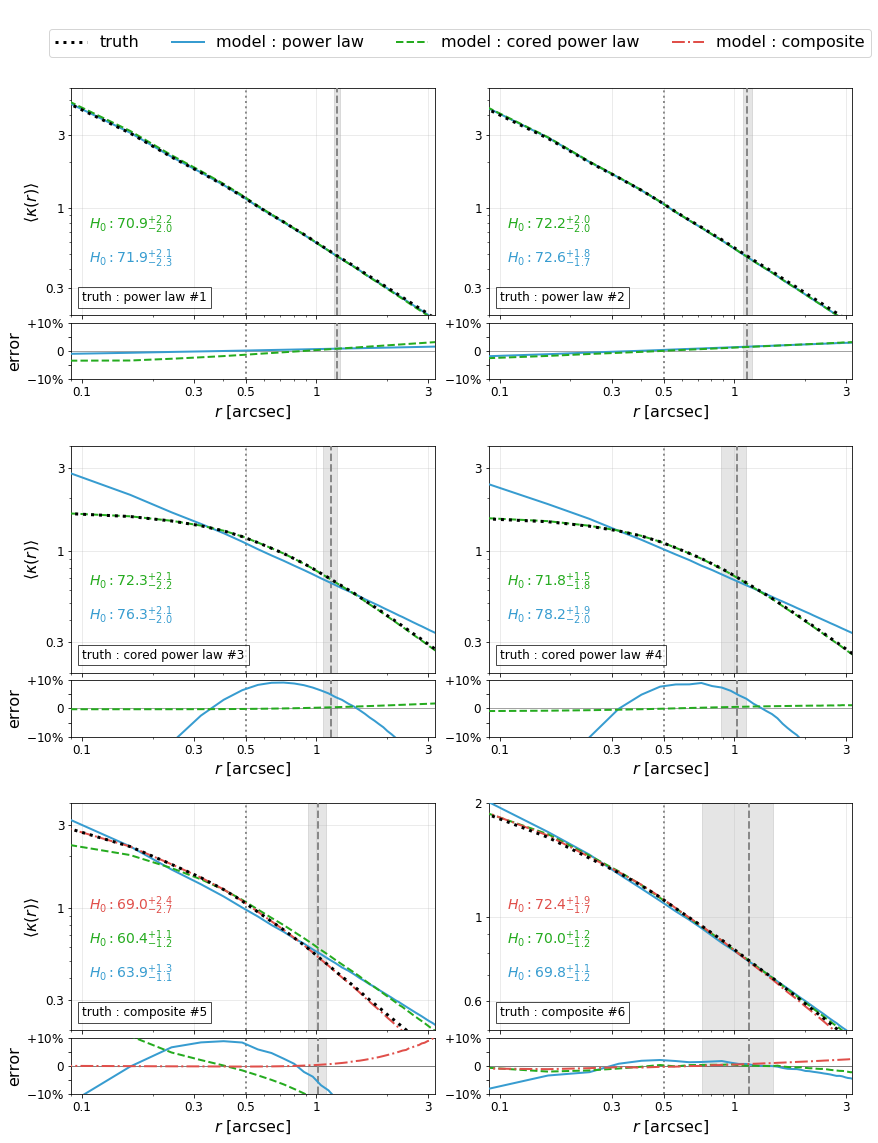

In [6]:
IPython.display.display(fig)
fig.savefig("radial_convergence_models.pdf", bbox_inches='tight')